<a href="https://colab.research.google.com/github/hejasevis/Credit-Approval-Dataset-Analysis/blob/main/Subset%20Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ucimlrepo scikit-learn matplotlib seaborn

In [2]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Fetch the dataset
credit_approval = fetch_ucirepo(id=27)

# Separating features (X) and target variable (y)
X = credit_approval.data.features
y = credit_approval.data.targets

# Encoding categorical and continuous features
X_encoded = pd.get_dummies(X, drop_first=True)

# Encode target variable
if isinstance(y, pd.DataFrame):  # If y is a DataFrame
    y = y.squeeze()

if y.dtype == "object":  # If target variable is string, encode
    le = LabelEncoder()
    y = le.fit_transform(y)

# Splitting into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)


In [4]:
# 1. Correlation Selection
# Determine correlation matrix and threshold
correlation_threshold = 0.85  # Correlation threshold
corr_matrix = X_train.corr(numeric_only=True).abs()

# Selection of highly correlated columns
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]

# Removing overly correlated columns
X_train_corr = X_train.drop(columns=to_drop)
print(f"Features after correlation selection: {X_train_corr.columns.tolist()}")

Features after correlation selection: ['A15', 'A14', 'A11', 'A8', 'A3', 'A2', 'A13_p', 'A13_s', 'A12_t', 'A10_t', 'A9_t', 'A7_dd', 'A7_ff', 'A7_h', 'A7_j', 'A7_n', 'A7_o', 'A7_v', 'A7_z', 'A6_c', 'A6_cc', 'A6_d', 'A6_e', 'A6_i', 'A6_j', 'A6_k', 'A6_m', 'A6_q', 'A6_r', 'A6_w', 'A6_x', 'A5_p', 'A1_b']


In [5]:
# 2. Recursive Feature Elimination (RFE)
# Recursive Feature Elimination process
estimator = RandomForestClassifier(random_state=42)
selector = RFE(estimator, n_features_to_select=5, step=1)  # En iyi 5 özelliği seç
selector = selector.fit(X_train_corr, y_train)

# Getting the selected features
selected_features_rfe = X_train_corr.columns[selector.support_]
print(f"Features selected by RFE: {selected_features_rfe.tolist()}")

### Model Training with Selected Features ###
# Feature extraction again with selected features
X_train_selected = X_train_corr[selected_features_rfe]
X_test_selected = X_test[selected_features_rfe]

Features selected by RFE: ['A15', 'A11', 'A8', 'A3', 'A9_t']


In [6]:
# Model training and testing performance
model = RandomForestClassifier(random_state=42)
model.fit(X_train_selected, y_train)
accuracy = model.score(X_test_selected, y_test)
print(f"Accuracy with selected features: {accuracy:.4f}")

Accuracy with selected features: 0.8478


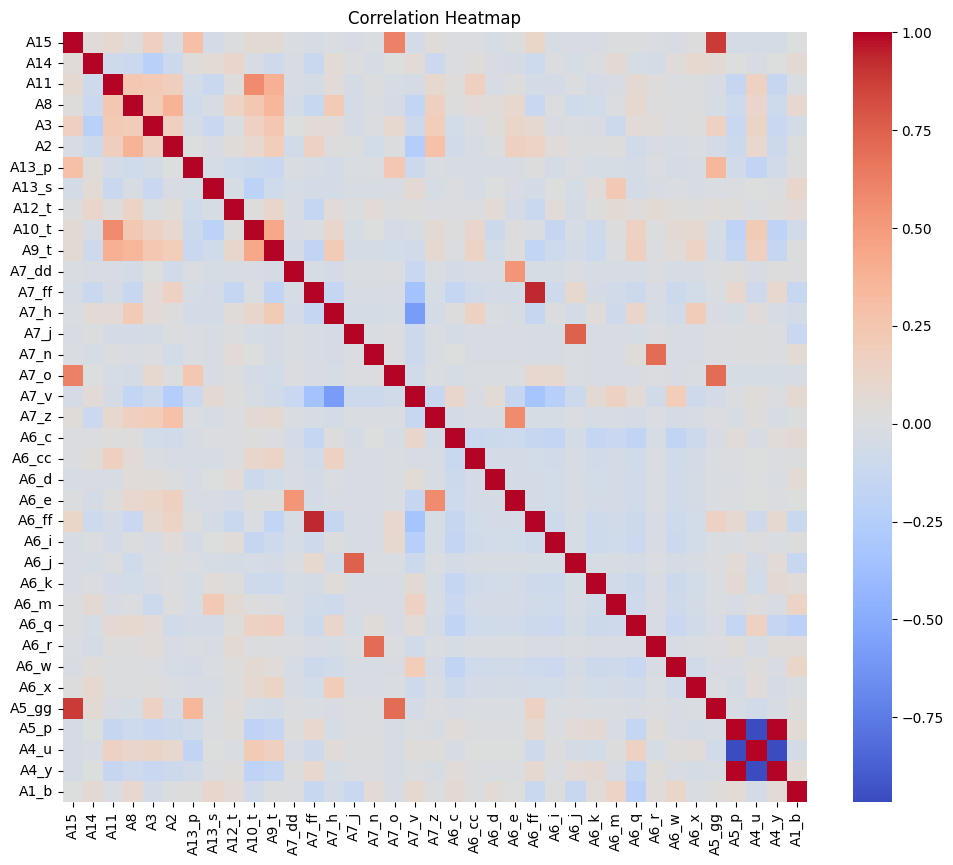

In [7]:
# Correlation Heat Map
plt.figure(figsize=(12, 10))
corr = X_train.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

In [8]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# Filling in missing values
imputer = SimpleImputer(strategy='most_frequent')  # Fill missing values ​​with the most frequently occurring value
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Convert target variable to appropriate format
if isinstance(y, pd.DataFrame):
    y = y.squeeze()  # Convert target variable to Series format

if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)  # Convert target variable to numeric values

# Coding of categorical data
X_encoded = pd.get_dummies(X_imputed, drop_first=True)

# Select the best features based on Chi-Square test
k_best = SelectKBest(chi2, k=5)  # Choose your top 5 features
X_selected = k_best.fit_transform(X_encoded, y)

# Get the names of the selected features
selected_features = X_encoded.columns[k_best.get_support()]
print("Chi-Square ile seçilen özellikler:", selected_features)

# Create new dataset
X_new = X_encoded[selected_features]


Chi-Square ile seçilen özellikler: Index(['A10_t', 'A9_t', 'A7_ff', 'A6_ff', 'A6_x'], dtype='object')


<ipython-input-9-5a3c93949a2c>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=selected_scores, y=selected_features, palette="viridis")


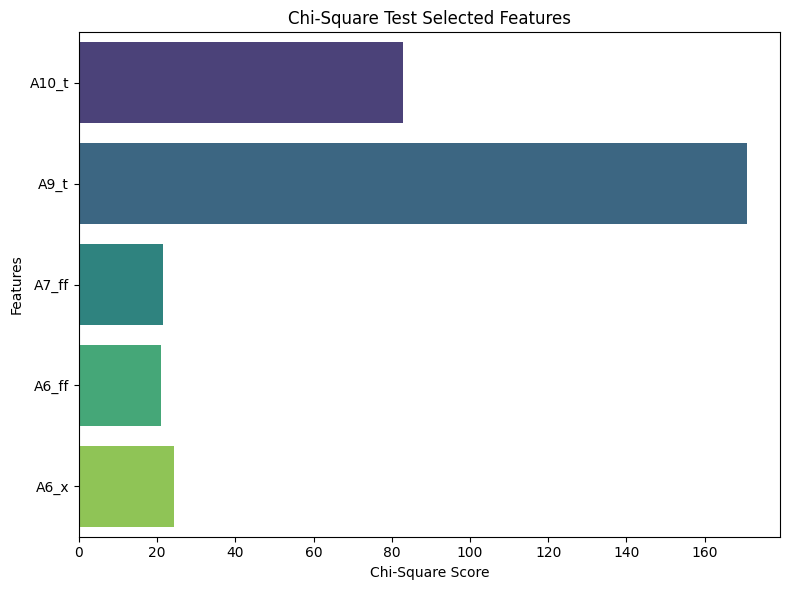

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Retrieve Chi-Square scores and selected features
chi2_scores = k_best.scores_
selected_scores = chi2_scores[k_best.get_support()]  # Scores of selected features
selected_features = X_encoded.columns[k_best.get_support()]  # Names of selected features

# Creating a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=selected_scores, y=selected_features, palette="viridis")
plt.title("Chi-Square Test Selected Features")
plt.xlabel("Chi-Square Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()
